In [1]:
%matplotlib inline
import os.path
import pandas
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import pickle
import itertools
import sourmash, sourmash.fig
import time

import numpy as np

import pylab
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
import collections

import altair as alt
from vega import VegaLite

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [72]:
# load data & sort by query column

def load_hu(filename):
    x = pandas.read_csv(filename)
    #x = x[x['best_containment'] > 0.95].reset_index(drop=True)
    return x

gbio_podarV = load_hu('gbio/podarV_k31_r1_search_oh0/results.csv')
gbio_hu = load_hu('gbio/hu-s1_k31_r1_search_oh0/results.csv')


v2_podarV = load_hu('v2/podarV_k31_r1_search_oh0/results.csv')
v2_podarV['query'] = v2_podarV['query'].apply(lambda x: x[x.find('podar-ref'):])

v2_hu = load_hu('v2/hu-s1_k31_r1_search_oh0/results.csv')
v2_hu['query'] = v2_hu['query'].apply(lambda x: x[x.find('hu-genomes'):])

x = set(gbio_podarV['query']) 
v2_podarV = v2_podarV[v2_podarV["query"].isin(x)]
print(len(v2_podarV))

x = set(gbio_hu['query'])
y = set(v2_hu['query'])

x = x.intersection(y)
v2_hu = v2_hu[v2_hu["query"].isin(x)]
gbio_hu = gbio_hu[gbio_hu["query"].isin(x)]

64


In [73]:
x = set(gbio_podarV['query']) 
v2_podarV = v2_podarV[v2_podarV["query"].isin(x)]
print(len(v2_podarV))

64


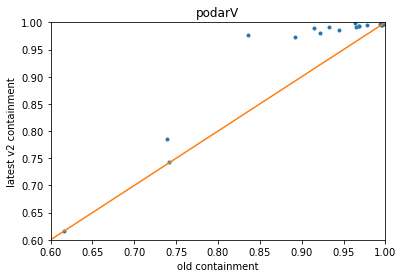

In [110]:
pyplot.plot(gbio_podarV.containment, v2_podarV.containment, '.')
pyplot.plot([0, 1], [0, 1])
pyplot.ylim((.6, 1.0))
pyplot.xlim((.6, 1.0))
pyplot.xlabel("old containment")
pyplot.ylabel("latest v2 containment")
pyplot.title("podarV")
pyplot.savefig("/tmp/podarV-containment.png")

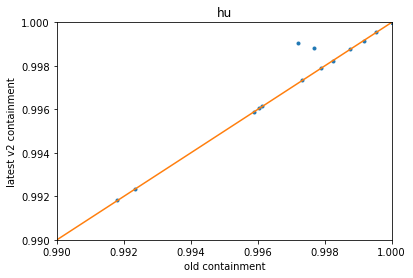

In [109]:
pyplot.plot(gbio_hu.containment, v2_hu.containment, '.')
pyplot.plot([0, 1], [0, 1])
pyplot.ylim((.99, 1.0))
pyplot.xlim((.99, 1.0))
pyplot.xlabel("old containment")
pyplot.ylabel("latest v2 containment")
pyplot.title("hu")
pyplot.savefig("/tmp/hu-containment.png")

In [82]:
# load the completion metrics for the basic bins
bins = {}
bincrumbs = {}

for row in open('gbio/files_checkm/checkm-hu.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        if 'cmbnd' in name:
            bincrumbs[genome] = (complete, contam, strain)
        else:
            bins[genome] = (complete, contam, strain)
            
#assert set(bins) == set(bincrumbs)

In [83]:
# load the completion metrics for the plass assemblies
plassbins = {}

for row in open('gbio/files_checkm/checkm-plass.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        plassbins[genome] = (complete, contam, strain)

In [84]:
# load the completion metrics for the megahit assemblies
megahit = {}

for row in open('gbio/files_checkm/checkm-megahit.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        megahit[genome] = (complete, contam, strain)

In [85]:
summary = []
for k in bins:
    row = [k]
    row.extend(bins[k])
    row.extend(plassbins[k])
    row.extend(megahit[k])
    summary.append(row)
    
gbio_checkm_df = pd.DataFrame(summary, columns=['genome', 'bin_complete', 'bin_contam', 'bin_strain',
                                    'plass_complete', 'plass_contam', 'plass_strain',
                                    'megahit_complete', 'megahit_contam', 'megahit_strain'])

print(len(gbio_checkm_df))

23


In [86]:
gbio_checkm_df['nt_diff'] = gbio_checkm_df['megahit_complete'] - gbio_checkm_df['bin_complete']
gbio_checkm_df['aa_diff'] = gbio_checkm_df['plass_complete'] - gbio_checkm_df['megahit_complete']
gbio_checkm_df['total_diff'] = gbio_checkm_df['plass_complete'] - gbio_checkm_df['bin_complete']

In [87]:
# load the completion metrics for the basic bins
bins = {}
bincrumbs = {}

for row in open('v2/checkm-hu.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        if 'cmbnd' in name:
            bincrumbs[genome] = (complete, contam, strain)
        else:
            bins[genome] = (complete, contam, strain)
            
# load the completion metrics for the plass assemblies
plassbins = {}

for row in open('v2/checkm-plass.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        plassbins[genome] = (complete, contam, strain)
        
# load the completion metrics for the megahit assemblies
megahit = {}

for row in open('v2/checkm-megahit.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        megahit[genome] = (complete, contam, strain)
        
summary = []
for k in bins:
    row = [k]
    row.extend(bins[k])
    row.extend(plassbins[k])
    row.extend(megahit[k])
    summary.append(row)
    
v2_checkm_df = pd.DataFrame(summary, columns=['genome', 'bin_complete', 'bin_contam', 'bin_strain',
                                    'plass_complete', 'plass_contam', 'plass_strain',
                                    'megahit_complete', 'megahit_contam', 'megahit_strain'])

print(len(v2_checkm_df))

v2_checkm_df['nt_diff'] = v2_checkm_df['megahit_complete'] - v2_checkm_df['bin_complete']
v2_checkm_df['aa_diff'] = v2_checkm_df['plass_complete'] - v2_checkm_df['megahit_complete']
v2_checkm_df['total_diff'] = v2_checkm_df['plass_complete'] - v2_checkm_df['bin_complete']

23


In [88]:
v2_checkm_df[:5]

,genome,bin_complete,bin_contam,bin_strain,plass_complete,plass_contam,plass_strain,megahit_complete,megahit_contam,megahit_strain,nt_diff,aa_diff,total_diff
0,hu-genome41,100.00,0.00,0.0,100.00,12465.90,76.98,100.00,10.47,46.94,0.00,0.00,0.00
1,hu-genome22,97.60,0.00,0.0,97.66,1362.84,86.75,98.40,10.91,67.86,0.80,-0.74,0.06
2,hu-genome37,94.51,0.00,0.0,95.69,315.90,90.61,94.51,2.20,0.00,0.00,1.18,1.18
3,hu-genome23,94.41,0.25,0.0,94.48,1206.57,84.82,94.99,2.03,14.29,0.58,-0.51,0.07
4,hu-genome39,94.17,2.78,20.0,98.12,1842.39,61.19,96.11,9.67,32.00,1.94,2.01,3.95


In [89]:
gbio_checkm_df[:5]

,genome,bin_complete,bin_contam,bin_strain,plass_complete,plass_contam,plass_strain,megahit_complete,megahit_contam,megahit_strain,nt_diff,aa_diff,total_diff
0,hu-genome41,100.00,0.00,0.0,95.83,7897.58,59.07,100.00,11.81,53.19,0.00,-4.17,-4.17
1,hu-genome22,97.60,0.00,0.0,97.66,853.97,70.02,98.40,10.82,67.86,0.80,-0.74,0.06
2,hu-genome37,94.51,0.00,0.0,96.36,249.17,90.15,94.51,1.65,0.00,0.00,1.85,1.85
3,hu-genome23,94.41,0.25,0.0,96.21,669.48,74.77,96.15,2.66,50.00,1.74,0.06,1.80
4,hu-genome39,94.17,2.78,20.0,98.12,1163.57,43.11,95.28,8.78,25.00,1.11,2.84,3.95


In [90]:
len(v2_checkm_df)

23

In [91]:
len(gbio_checkm_df)

23

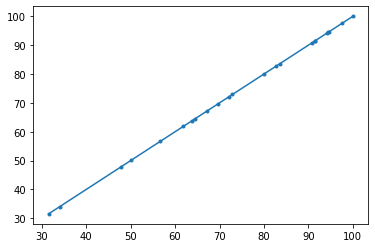

In [95]:
pyplot.plot(gbio_checkm_df.bin_complete, v2_checkm_df.bin_complete, '.-')

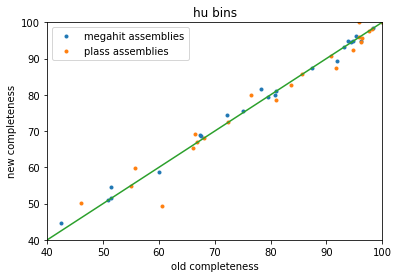

In [108]:
pyplot.plot(gbio_checkm_df.megahit_complete, v2_checkm_df.megahit_complete, '.', label='megahit assemblies')
pyplot.plot(gbio_checkm_df.plass_complete, v2_checkm_df.plass_complete, '.', label='plass assemblies')
pyplot.plot([0, 100], [0,100], '-')
pyplot.xlabel('old completeness')
pyplot.ylabel('new completeness')
pyplot.ylim((40, 100))
pyplot.xlim((40, 100))
pyplot.title("hu bins")
pyplot.legend(loc='upper left')
pyplot.savefig("/tmp/hu-checkm.png")

# Thoughts

value of repro is in this kind of thing - running new version on old data, running old version on new data

kind of a regression test